## imports & installations

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys
import itertools
import os
from scipy.stats import normaltest
from itertools import groupby
import datetime

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import analysis.calc_single_cell_properties as calculator 
import analysis.utils as utils
import data_layer.utils as data_utils
import configuration.consts as consts

## data loading - differentiation scores dataframes

In [2]:
scores_df_s3 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S3.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S3.pkl")

scores_df_s2 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S2.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S2.pkl")

scores_df_s5 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S5.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S5.pkl")

scores_df_s1 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S1.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S1.pkl")

Calculate single cell properties

In [3]:
scores_df_s3 = calculator.get_properties(scores_df_s3, vid_name="S3", actin_vid_path=consts.vid_info_dict["3"]['actin_path'])
scores_df_s2 = calculator.get_properties(scores_df_s2, vid_name="S2", actin_vid_path=consts.vid_info_dict["2"]['actin_path'])
scores_df_s5 = calculator.get_properties(scores_df_s5, vid_name="S5", actin_vid_path=consts.vid_info_dict["5"]['actin_path'])
scores_df_s1 = calculator.get_properties(scores_df_s1, vid_name="S1", actin_vid_path=consts.vid_info_dict["1"]['actin_path'])

Plotting how much change happened in comparison to the initial time point for individual cells during differentiation could also be helpful.

In [7]:
def calc_diff_score_change(x, modality, initial_time_point, final_time_point):
    initial_time_score = x[x["time"]==initial_time_point][f"score_{modality}"].values
    final_time_score = x[x["time"]==final_time_point][f"score_{modality}"].values
    change = np.nan
    if len(initial_time_score) > 0 and len(final_time_score) > 0 :
        change = final_time_score[0] - initial_time_score[0]
    return change
            
def plot_dist_diff_score_change(df_scores, modality, method):
    def calc_diff_score_change_by_method(x, modality, method):
        if method == "global_time":
            initial_time_point = 6
            final_time_point = 13
        elif method == "steady_threshold":
            final_time_point = calculator.get_stable_threshold_time(x, (0.7, 0.8), modality, time_point="first")
            initial_time_point = calculator.get_stable_threshold_time(x, (0.2, 0.3), modality, time_point="last", time_thresh=final_time_point)

        elif method == "track_start_to_global_time":
            initial_time_point = x.dropna(subset=f"score_{modality}")["time"].min()
            final_time_point = 13

        change = calc_diff_score_change(x, modality, initial_time_point, final_time_point)
        return change
        
    data = df_scores.groupby(['Spot track ID']).apply(lambda x: calc_diff_score_change_by_method(x, modality, method=method))
    print(method, modality)
    print("number of cells in the analysis: ", len(data.dropna()))
    mean, std, median = round(data.mean(), 3), round(data.std(), 3), round(data.median(), 3)
    print(f"mean: {mean}, std: {std}, median: {median}")
    plt.hist(data)
    plt.xlim((-1, 1))
    plt.ylim((0, 110))
    plt.show()

In [8]:
def calc_initial_time_point(track, modality):
        initial_time_point = track.dropna(subset=f"score_{modality}")["time"].min()
        return initial_time_point
    
def calc_initial_score(track, modality):
        initial_time_point = track[f"initial_time_point_{modality}"].iloc[0]
        initial_score = track[track["time"] == initial_time_point][f"score_{modality}"].iloc[0]
        return initial_score

In [24]:
fig_dir_path = fr"/storage/users/assafzar/Muscle_Differentiation_AvinoamLab/eps_figs/"

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


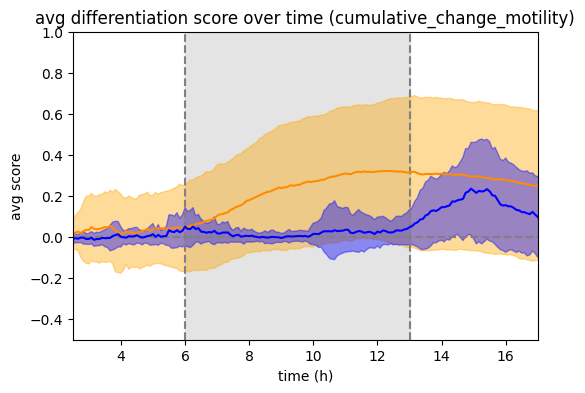

<Figure size 640x480 with 0 Axes>

In [25]:
scores_df_s3 = calculator.get_property(scores_df_s3, "initial_time_point", "motility", calc_initial_time_point, {"motility"})
scores_df_s3 = calculator.get_property(scores_df_s3, "initial_score", "motility", calc_initial_score, {"motility"})
scores_df_s3["score_cumulative_change_motility"] = scores_df_s3["score_motility"] - scores_df_s3["initial_score_motility"]

scores_df_s2 = calculator.get_property(scores_df_s2, "initial_time_point", "motility", calc_initial_time_point, {"motility"})
scores_df_s2 = calculator.get_property(scores_df_s2, "initial_score", "motility", calc_initial_score, {"motility"})
scores_df_s2["score_cumulative_change_motility"] = scores_df_s2["score_motility"] - scores_df_s2["initial_score_motility"]

utils.plot_avg_conf([(scores_df_s3, "ERKi", "DarkOrange","Orange"),
                    (scores_df_s2, "DMSO", "Blue","Blue")],
                    "cumulative_change_motility", path=fig_dir_path + "cumulative_change_motility", plot_std=True, time=(6,13), xlim=(2.5, 17), ylim=(-0.5, 1), axhline_val=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


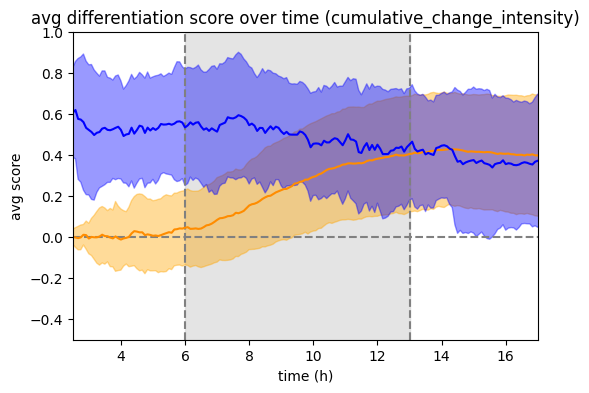

<Figure size 640x480 with 0 Axes>

In [26]:
scores_df_s3 = calculator.get_property(scores_df_s3, "initial_time_point", "intensity", calc_initial_time_point, {"intensity"})
scores_df_s3 = calculator.get_property(scores_df_s3, "initial_score", "intensity", calc_initial_score, {"intensity"})
scores_df_s3["score_cumulative_change_intensity"] = scores_df_s3["score_intensity"] - scores_df_s3["initial_score_intensity"]

scores_df_s2 = calculator.get_property(scores_df_s2, "initial_time_point", "intensity", calc_initial_time_point, {"intensity"})
scores_df_s2 = calculator.get_property(scores_df_s2, "initial_score", "intensity", calc_initial_score, {"intensity"})
scores_df_s2["score_cumulative_change_intensity"] = scores_df_s3["score_intensity"] - scores_df_s2["initial_score_intensity"]

utils.plot_avg_conf([(scores_df_s3, "ERKi", "DarkOrange","Orange"),
                    (scores_df_s2, "DMSO", "Blue","Blue")],
                    "cumulative_change_intensity", path=fig_dir_path + "cumulative_change_intensity", plot_std=True, time=(6,13), xlim=(2.5, 17), ylim=(-0.5, 1), axhline_val=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


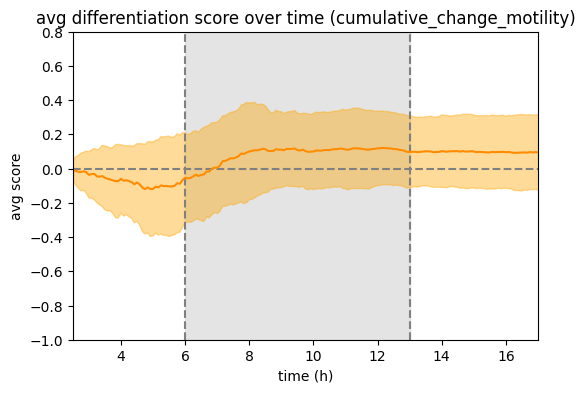

<Figure size 640x480 with 0 Axes>

In [22]:
scores_df_s5 = calculator.get_property(scores_df_s5, "initial_time_point", "motility", calc_initial_time_point, {"motility"})
scores_df_s5 = calculator.get_property(scores_df_s5, "initial_score", "motility", calc_initial_score, {"motility"})
scores_df_s5["score_cumulative_change_motility"] = scores_df_s5["score_motility"] - scores_df_s5["initial_score_motility"]
utils.plot_avg_conf([(scores_df_s5, "ERKi", "DarkOrange","Orange")], "cumulative_change_motility", path="", plot_std=True, time=(6,13), xlim=(2.5, 17), ylim=(-1, 0.8), axhline_val=0)

global_time motility
number of cells in the analysis:  182
mean: 0.392, std: 0.34, median: 0.421


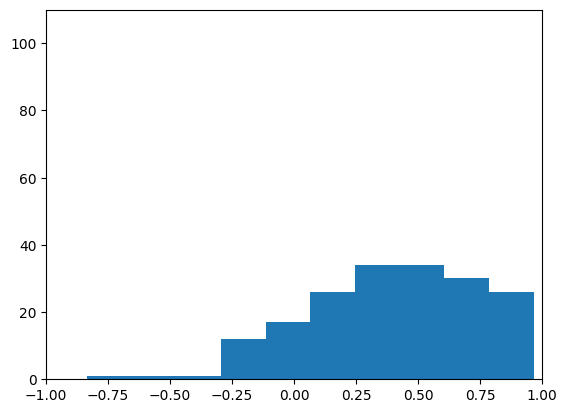

track_start_to_global_time motility
number of cells in the analysis:  569
mean: 0.314, std: 0.366, median: 0.313


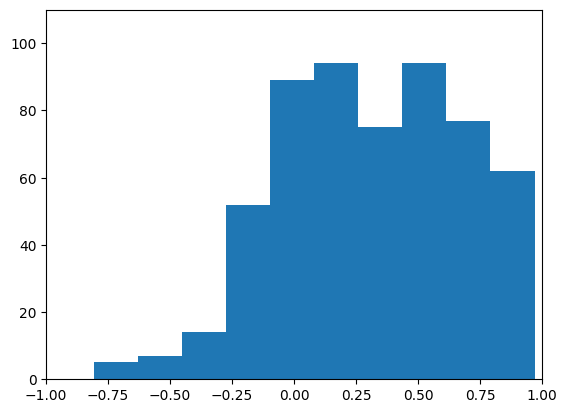

steady_threshold motility
number of cells in the analysis:  425
mean: 0.496, std: 0.038, median: 0.497


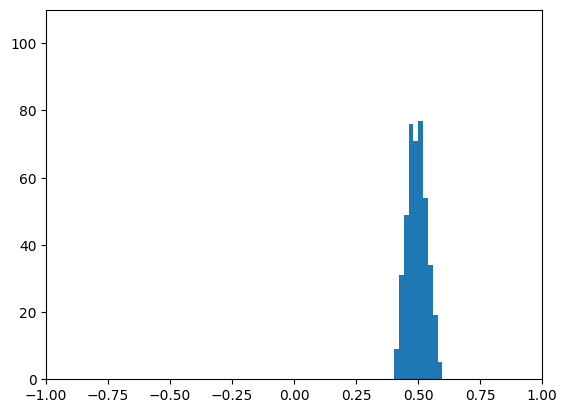

In [19]:
plot_dist_diff_score_change(scores_df_s3, "motility", "global_time")
plot_dist_diff_score_change(scores_df_s3, "motility", "track_start_to_global_time")
plot_dist_diff_score_change(scores_df_s3, "motility", "steady_threshold")

global_time intensity
number of cells in the analysis:  182
mean: 0.448, std: 0.301, median: 0.502


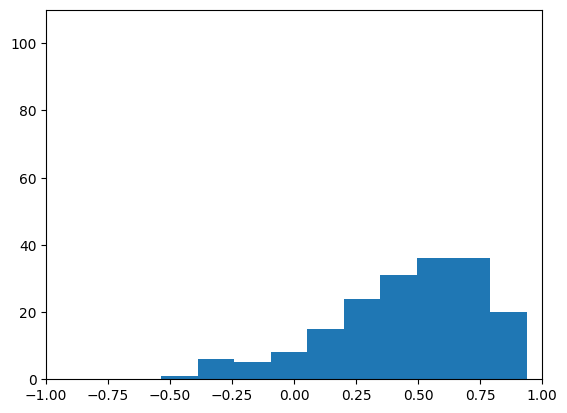

track_start_to_global_time intensity
number of cells in the analysis:  569
mean: 0.404, std: 0.282, median: 0.436


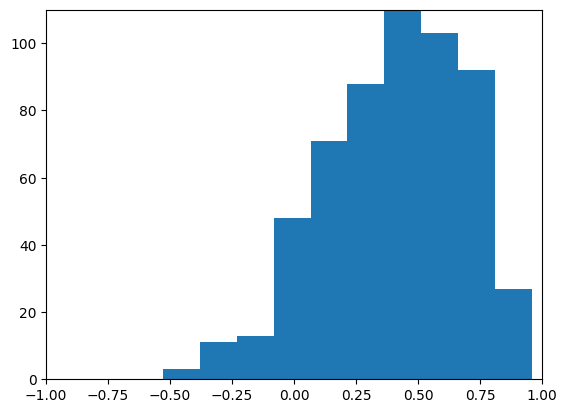

steady_threshold intensity
number of cells in the analysis:  496
mean: 0.497, std: 0.039, median: 0.497


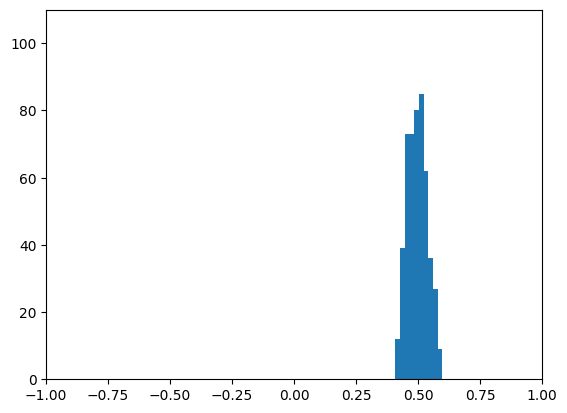

In [20]:
plot_dist_diff_score_change(scores_df_s3, "intensity", "global_time")
plot_dist_diff_score_change(scores_df_s3, "intensity", "track_start_to_global_time")
plot_dist_diff_score_change(scores_df_s3, "intensity", "steady_threshold")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


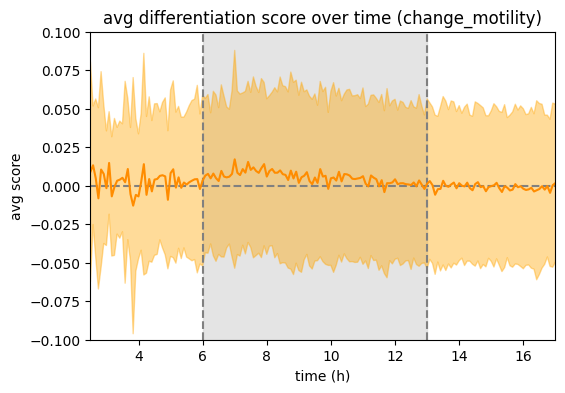

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

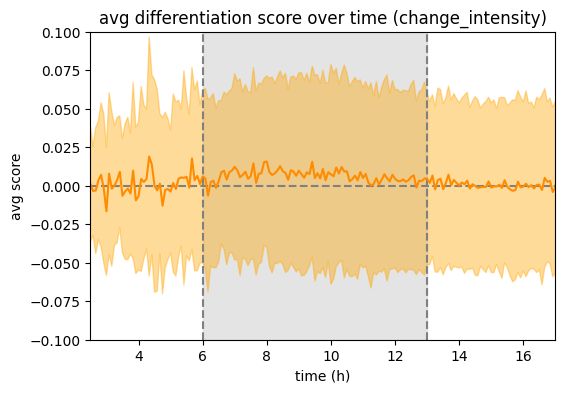

<Figure size 640x480 with 0 Axes>

In [27]:
scores_df_s3["score_change_motility"] = scores_df_s3.groupby("Spot track ID")["score_motility"].diff()
scores_df_s3["score_change_intensity"] = scores_df_s3.groupby("Spot track ID")["score_intensity"].diff()

utils.plot_avg_conf([(scores_df_s3, "ERKi", "DarkOrange","Orange")], "change_motility", path=fig_dir_path + "change_motility", plot_std=True, time=(6,13), xlim=(2.5, 17), ylim=(-0.1, 0.1), axhline_val=0)
utils.plot_avg_conf([(scores_df_s3, "ERKi", "DarkOrange","Orange")], "change_intensity", path=fig_dir_path + "change_intensity", plot_std=True, time=(6,13), xlim=(2.5, 17), ylim=(-0.1, 0.1), axhline_val=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


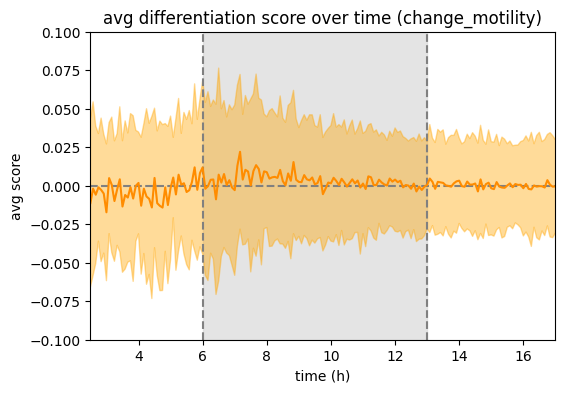

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

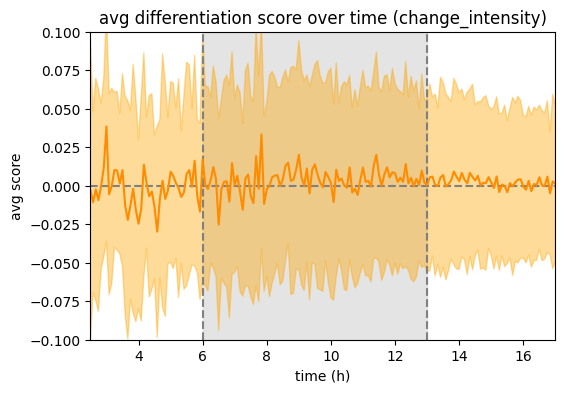

<Figure size 640x480 with 0 Axes>

In [13]:
scores_df_s5["score_change_motility"] = scores_df_s5.groupby("Spot track ID")["score_motility"].diff()
scores_df_s5["score_change_intensity"] = scores_df_s5.groupby("Spot track ID")["score_intensity"].diff()

utils.plot_avg_conf([(scores_df_s5, "ERKi", "DarkOrange","Orange")], "change_motility", path="", plot_std=True, time=(6,13), xlim=(2.5, 17), ylim=(-0.1, 0.1), axhline_val=0)
utils.plot_avg_conf([(scores_df_s5, "ERKi", "DarkOrange","Orange")], "change_intensity", path="", plot_std=True, time=(6,13), xlim=(2.5, 17), ylim=(-0.1, 0.1), axhline_val=0)

We will include confidence intervals or SEM wherever appropriate.  